<a href="https://colab.research.google.com/github/harshitrajssss/finetune-paligemma-on-detection-dataset/blob/main/finetune_paligemma_on_detection_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git@from_paligemma_support

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [17]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('roboflow')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("fernando-vela-rdnuo").project("retinopatia-diabetica")
version = project.version(1)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


In [18]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"1-77-_png_jpg.rf.f844dbdcbf0aa8388062c1155dfa9e93.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0278><loc0172><loc0861><loc0701> diabetic retinopathy"}
{"image":"1-9-_png_jpg.rf.f0424fb5adce76503cfab44d1d98a560.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0854><loc0346><loc1019><loc0659> diabetic retinopathy"}
{"image":"1-52-_png_jpg.rf.ed7721deebd6f3414bf6492da03592a7.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0000><loc0171><loc0435><loc0796> diabetic retinopathy"}
{"image":"tek-9-_jpeg_jpg.rf.f93b15f9a7523f967ac683b3eee5fea9.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0286><loc0216><loc0833><loc0743> eksudat"}
{"image":"1-84-_png_jpg.rf.ed074e8497574d9e7ca5b73c01d86355.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0025><loc0570><loc0496><loc0902> diabetic retinopathy"}


In [19]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"zme-8-_jpeg_jpg.rf.06a920c1e901cbb4ca1548e4e606c766.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0211><loc0271><loc0831><loc0808> eksudat"}
{"image":"ek-2-Copy_jpeg_jpg.rf.0e924062e3bbccf54c3378d0aacc4ff0.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0170><loc0316><loc0717><loc0764> eksudat"}
{"image":"1-100-_png_jpg.rf.0baaf95d3517bec0c988d787a015c453.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0848><loc0406><loc0990><loc0664> diabetic retinopathy"}
{"image":"1-108-_png_jpg.rf.159dc20c4602b008f73496c570d57740.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0478><loc0246><loc0887><loc0544> diabetic retinopathy"}
{"image":"1-5-_png_jpg.rf.163c8808a490453f417cfb2c9fb0e7b2.jpg","prefix":"detect diabetic retinopathy ; eksudat","suffix":"<loc0411><loc0055><loc0630><loc0471> diabetic retinopathy"}


**NOTE:** Let's verify if the dataset conversion was successful.

{
    "image": "1-77-_png_jpg.rf.f844dbdcbf0aa8388062c1155dfa9e93.jpg",
    "prefix": "detect diabetic retinopathy ; eksudat",
    "suffix": "<loc0278><loc0172><loc0861><loc0701> diabetic retinopathy"
}


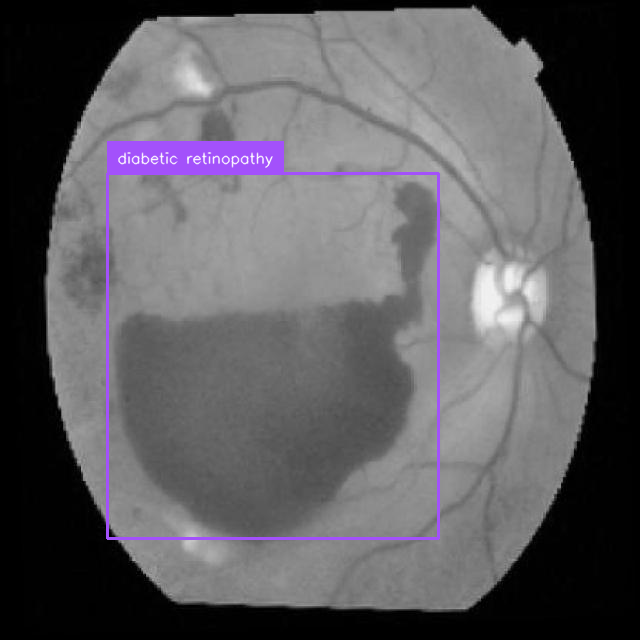

In [20]:
import json
import supervision as sv
from PIL import Image

first = json.loads(open(f"{dataset.location}/dataset/_annotations.train.jsonl").readline())
print(json.dumps(first, indent=4))

image = Image.open(f"{dataset.location}/dataset/{first.get('image')}")
CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=first.get('suffix'),
    resolution_wh=image.size,
    classes=CLASSES)

image = sv.BoundingBoxAnnotator().annotate(image, detections)
image = sv.LabelAnnotator().annotate(image, detections)
image

## Setup

In [21]:

import os
import sys
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo


if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


In [22]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [24]:

import os
import kagglehub

MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [00:58<00:00, 100MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


## Training

In [26]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns


import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [27]:

model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

params = paligemma.load(None, MODEL_PATH, model_config)

decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [28]:

def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [30]:


def preprocess_image(image, size=224):
  image = np.asarray(image)
  if image.ndim == 2:
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)
  mask_loss = [0] * len(tokens)

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)
    mask_loss += [1] * len(suffix)

  mask_input = [1] * len(tokens)
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()
  try:
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [31]:

SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""

  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



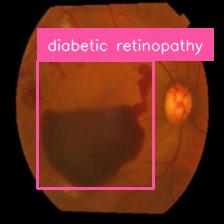
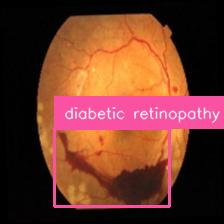
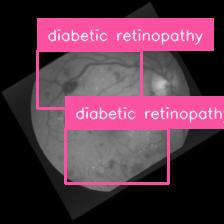
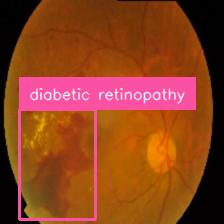

In [32]:

def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [33]:

@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    token_pplx = jnp.sum(logp * targets, axis=-1)
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)

    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)


  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:

    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)
    except StopIteration:
      if len(examples) == 0:
        return outputs

    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)

    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)


    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

Model predictions



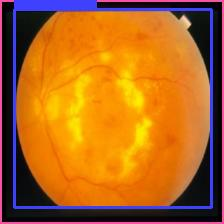
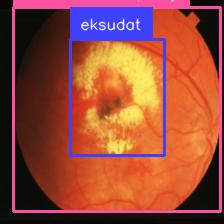
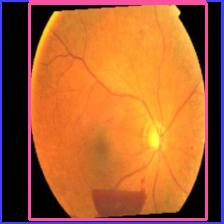
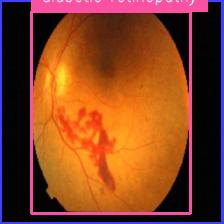
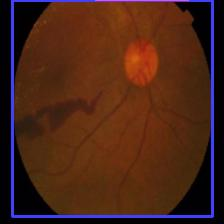
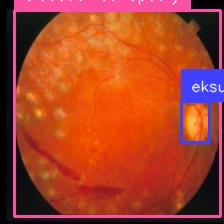
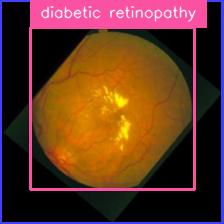
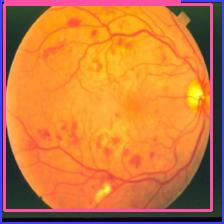

In [34]:

print("Model predictions")
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=8, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

In [35]:

targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), batch_size=4):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

In [36]:

mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.02
map50: 0.03
map75: 0.02


step:  1/64   lr: 0.00167   loss: 4.3002
Model predictions at step 1



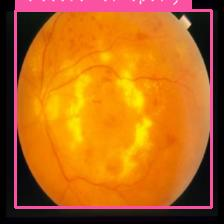
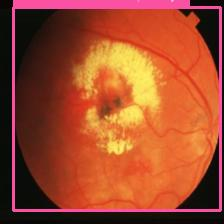
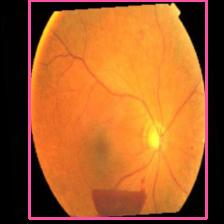
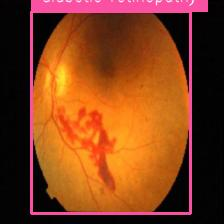

step:  2/64   lr: 0.00333   loss: 3.2411
step:  3/64   lr: 0.00500   loss: 3.0513
step:  4/64   lr: 0.00667   loss: 2.9316
step:  5/64   lr: 0.00833   loss: 4.3208
step:  6/64   lr: 0.01000   loss: 2.7845
step:  7/64   lr: 0.00999   loss: 3.1246
step:  8/64   lr: 0.00997   loss: 3.0523
Model predictions at step 8



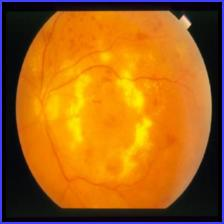
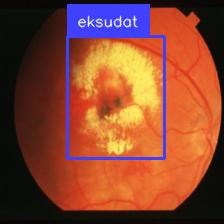
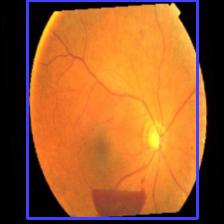
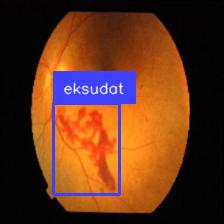

step:  9/64   lr: 0.00994   loss: 3.5112
step: 10/64   lr: 0.00989   loss: 3.4728
step: 11/64   lr: 0.00982   loss: 2.7086
step: 12/64   lr: 0.00975   loss: 2.7672
step: 13/64   lr: 0.00966   loss: 2.7892
step: 14/64   lr: 0.00955   loss: 2.4920
step: 15/64   lr: 0.00944   loss: 2.6963
step: 16/64   lr: 0.00931   loss: 2.4425
Model predictions at step 16



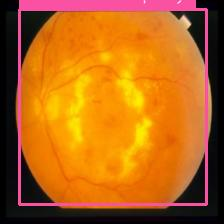
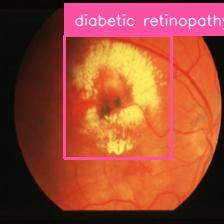
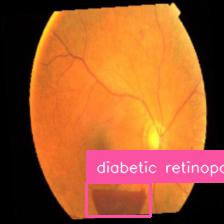
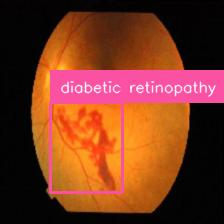

step: 17/64   lr: 0.00917   loss: 2.2009
step: 18/64   lr: 0.00901   loss: 2.6964
step: 19/64   lr: 0.00885   loss: 2.4721
step: 20/64   lr: 0.00867   loss: 2.3582
step: 21/64   lr: 0.00849   loss: 2.6749
step: 22/64   lr: 0.00829   loss: 2.3542
step: 23/64   lr: 0.00809   loss: 2.1511
step: 24/64   lr: 0.00787   loss: 2.6068
Model predictions at step 24



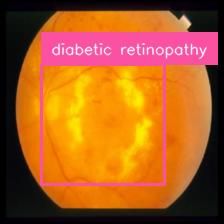
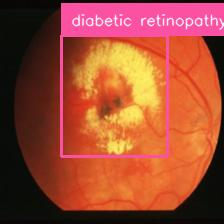
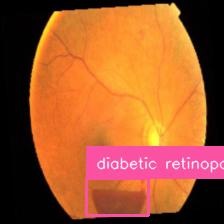
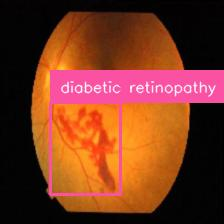

step: 25/64   lr: 0.00765   loss: 2.1184
step: 26/64   lr: 0.00742   loss: 2.5092
step: 27/64   lr: 0.00719   loss: 2.2355
step: 28/64   lr: 0.00694   loss: 2.3021
step: 29/64   lr: 0.00670   loss: 2.4845
step: 30/64   lr: 0.00644   loss: 2.5673
step: 31/64   lr: 0.00619   loss: 2.3753
step: 32/64   lr: 0.00593   loss: 2.3764
Model predictions at step 32



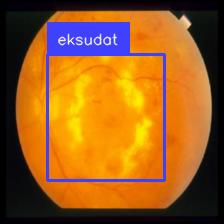
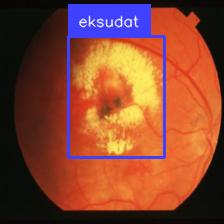
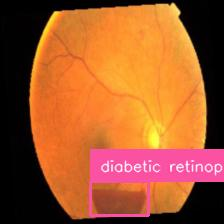
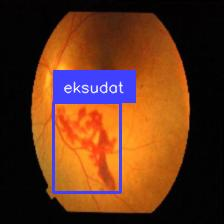

step: 33/64   lr: 0.00566   loss: 2.5295
step: 34/64   lr: 0.00540   loss: 2.6524
step: 35/64   lr: 0.00513   loss: 2.3533
step: 36/64   lr: 0.00487   loss: 2.2313
step: 37/64   lr: 0.00460   loss: 2.3137
step: 38/64   lr: 0.00434   loss: 2.3388
step: 39/64   lr: 0.00407   loss: 2.2778
step: 40/64   lr: 0.00381   loss: 2.3742
Model predictions at step 40



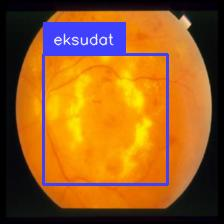
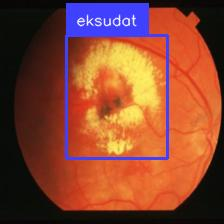
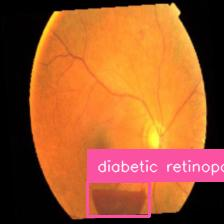
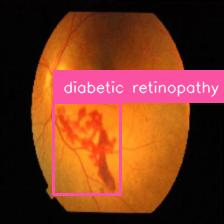

step: 41/64   lr: 0.00356   loss: 2.4721
step: 42/64   lr: 0.00330   loss: 2.0421
step: 43/64   lr: 0.00306   loss: 2.2060
step: 44/64   lr: 0.00281   loss: 2.3233
step: 45/64   lr: 0.00258   loss: 1.8637
step: 46/64   lr: 0.00235   loss: 2.2854
step: 47/64   lr: 0.00213   loss: 2.1940
step: 48/64   lr: 0.00191   loss: 2.1639
Model predictions at step 48



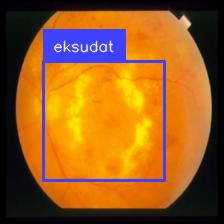
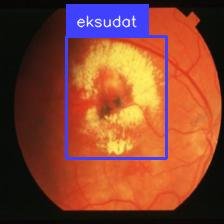
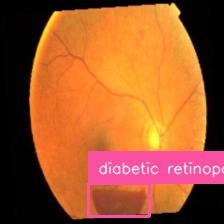
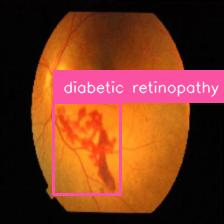

step: 49/64   lr: 0.00171   loss: 2.0150
step: 50/64   lr: 0.00151   loss: 2.0943
step: 51/64   lr: 0.00133   loss: 2.0283
step: 52/64   lr: 0.00115   loss: 2.0452
step: 53/64   lr: 0.00099   loss: 1.9291
step: 54/64   lr: 0.00083   loss: 2.1855
step: 55/64   lr: 0.00069   loss: 2.1497
step: 56/64   lr: 0.00056   loss: 2.3001
Model predictions at step 56



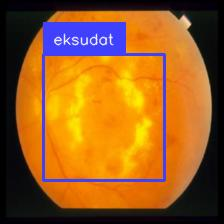
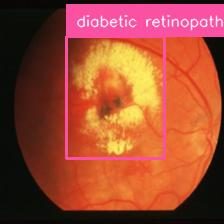
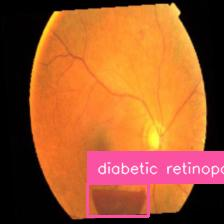
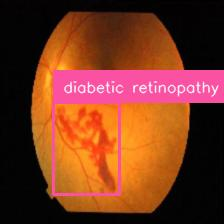

step: 57/64   lr: 0.00045   loss: 2.0452
step: 58/64   lr: 0.00034   loss: 2.2632
step: 59/64   lr: 0.00025   loss: 2.3178
step: 60/64   lr: 0.00018   loss: 2.2487
step: 61/64   lr: 0.00011   loss: 2.4974
step: 62/64   lr: 0.00006   loss: 1.9520
step: 63/64   lr: 0.00003   loss: 2.2480
step: 64/64   lr: 0.00001   loss: 2.0212
Model predictions at step 64



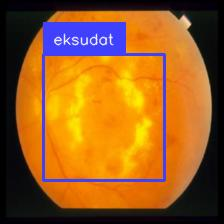
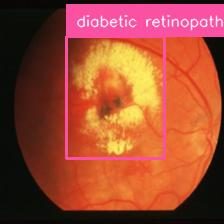
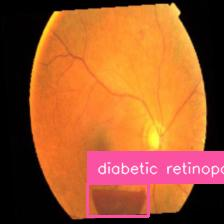
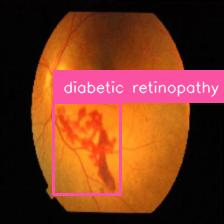

CPU times: user 11min 17s, sys: 798 ms, total: 11min 18s
Wall time: 11min 43s


In [37]:

%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.01

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):

  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if step == 1 or (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))



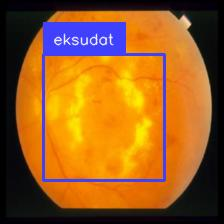
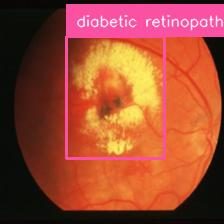
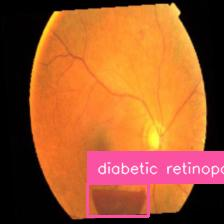
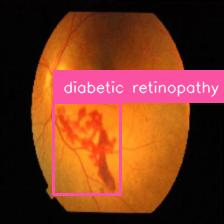
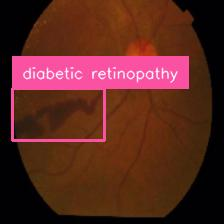
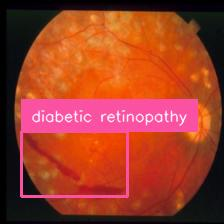
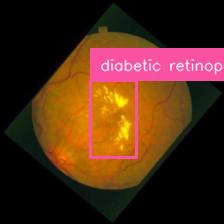
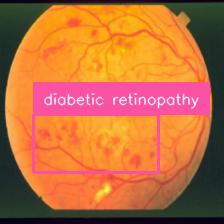
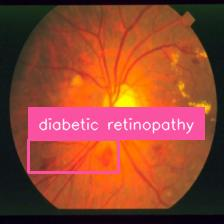
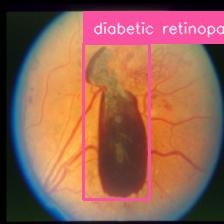
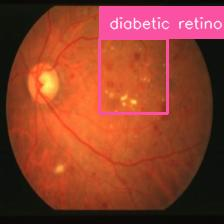
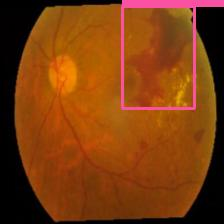
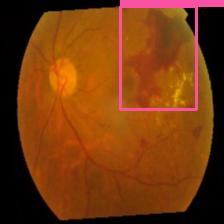
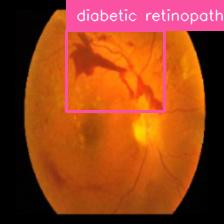
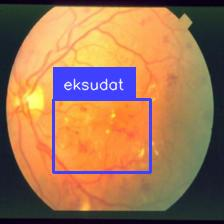
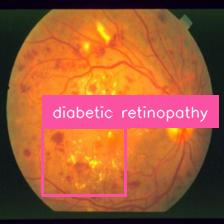
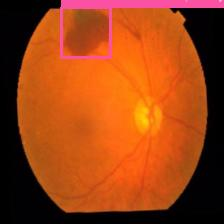
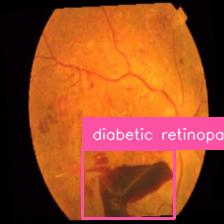
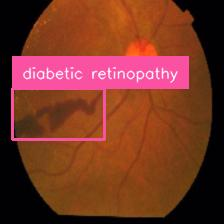
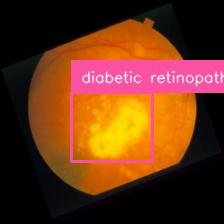
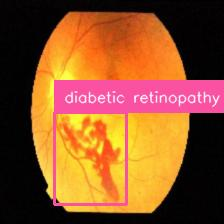
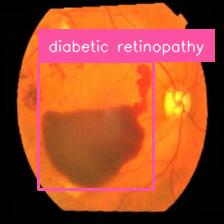
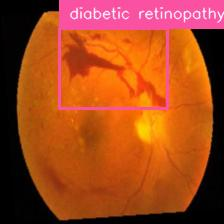
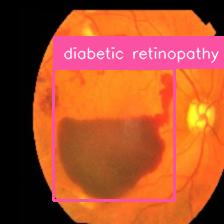
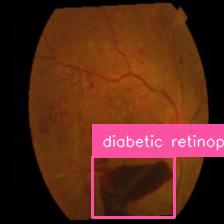
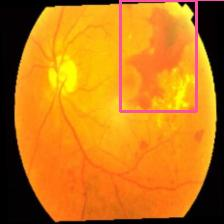
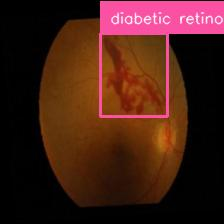
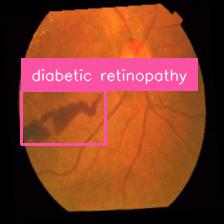
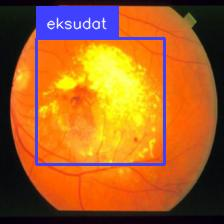
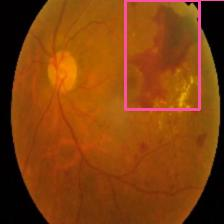
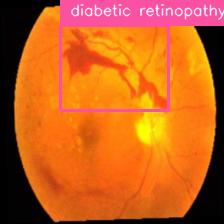
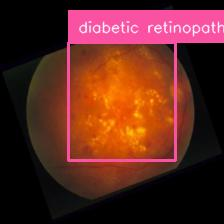
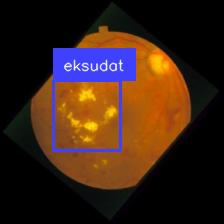
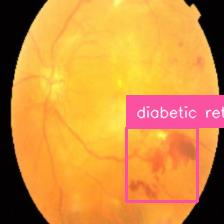
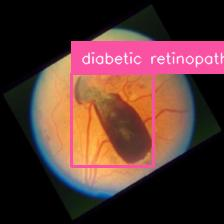
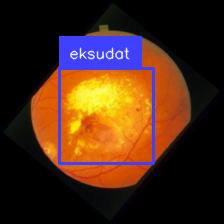
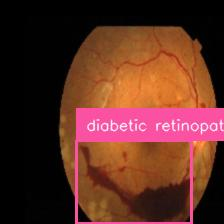
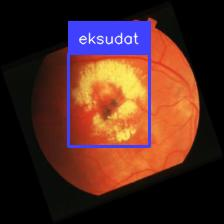
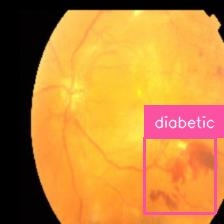
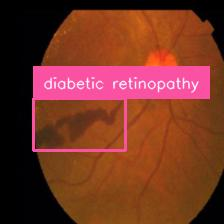
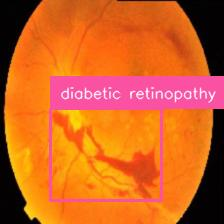
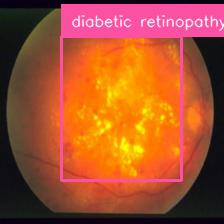
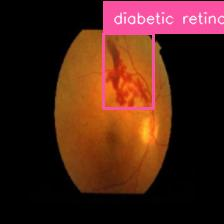
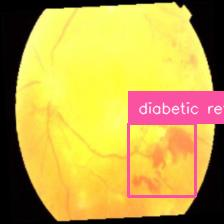
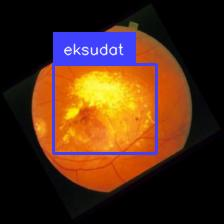
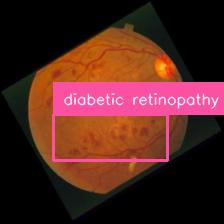
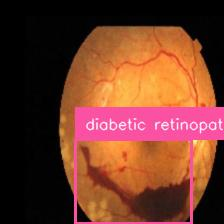
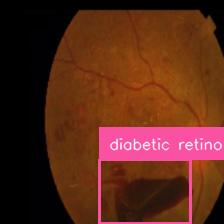
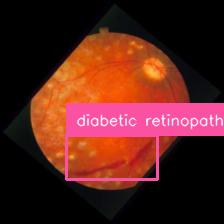
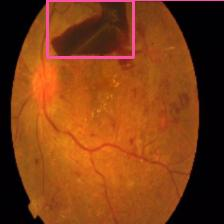
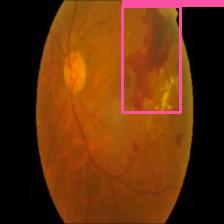
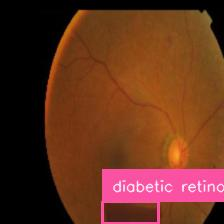
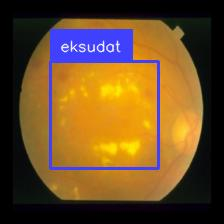
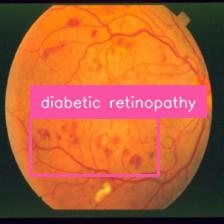
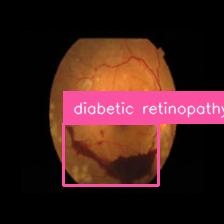
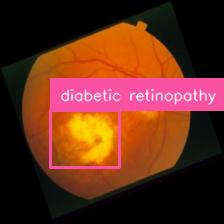
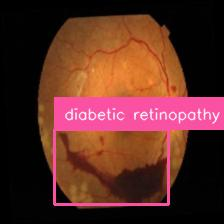
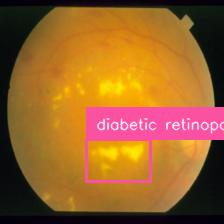
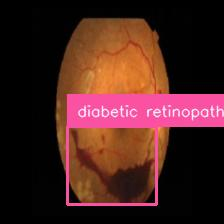
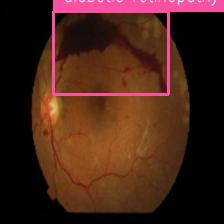
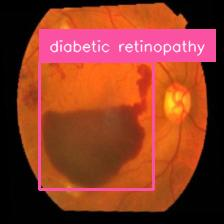
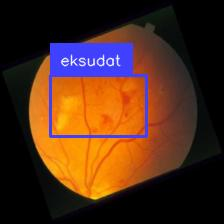
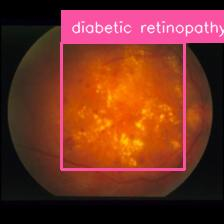
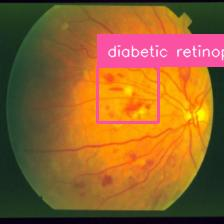
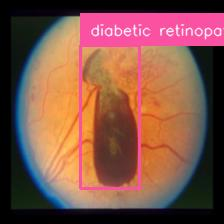
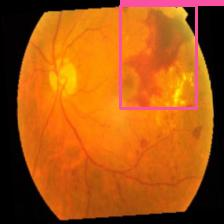
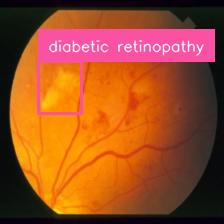
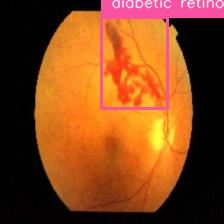
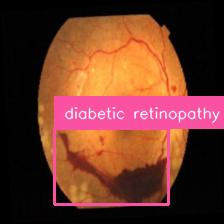
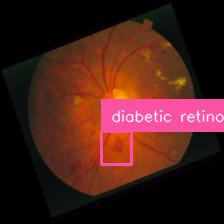
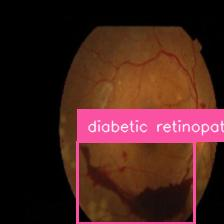
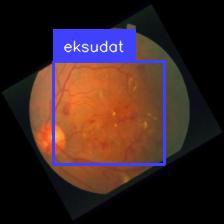
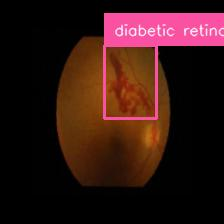
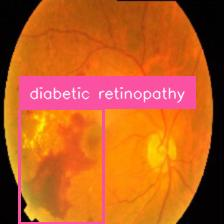
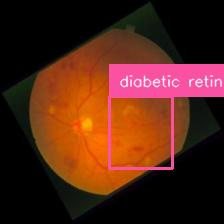
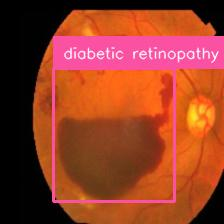
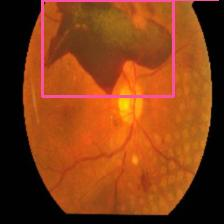
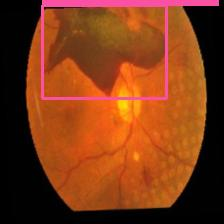
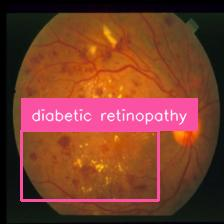
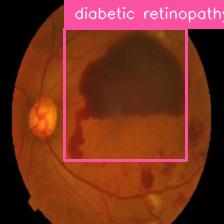
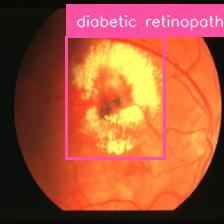
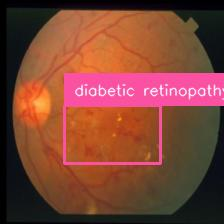
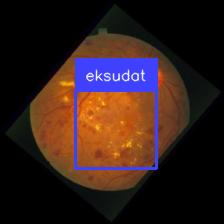
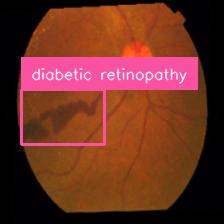
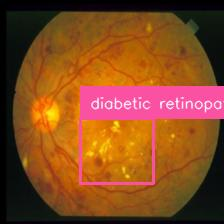
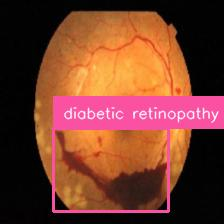
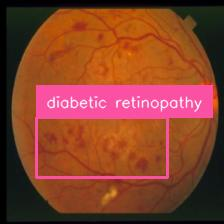
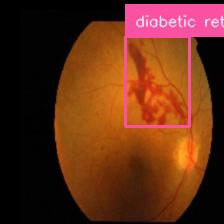
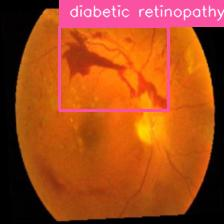
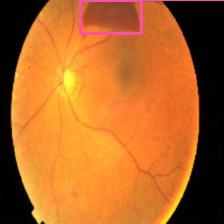
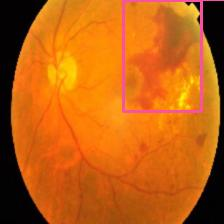
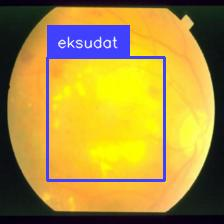
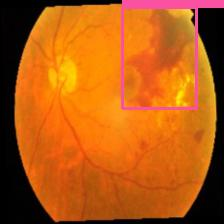

In [38]:

html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


In [39]:
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), batch_size=4):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

In [40]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.46
map50: 0.59
map75: 0.49


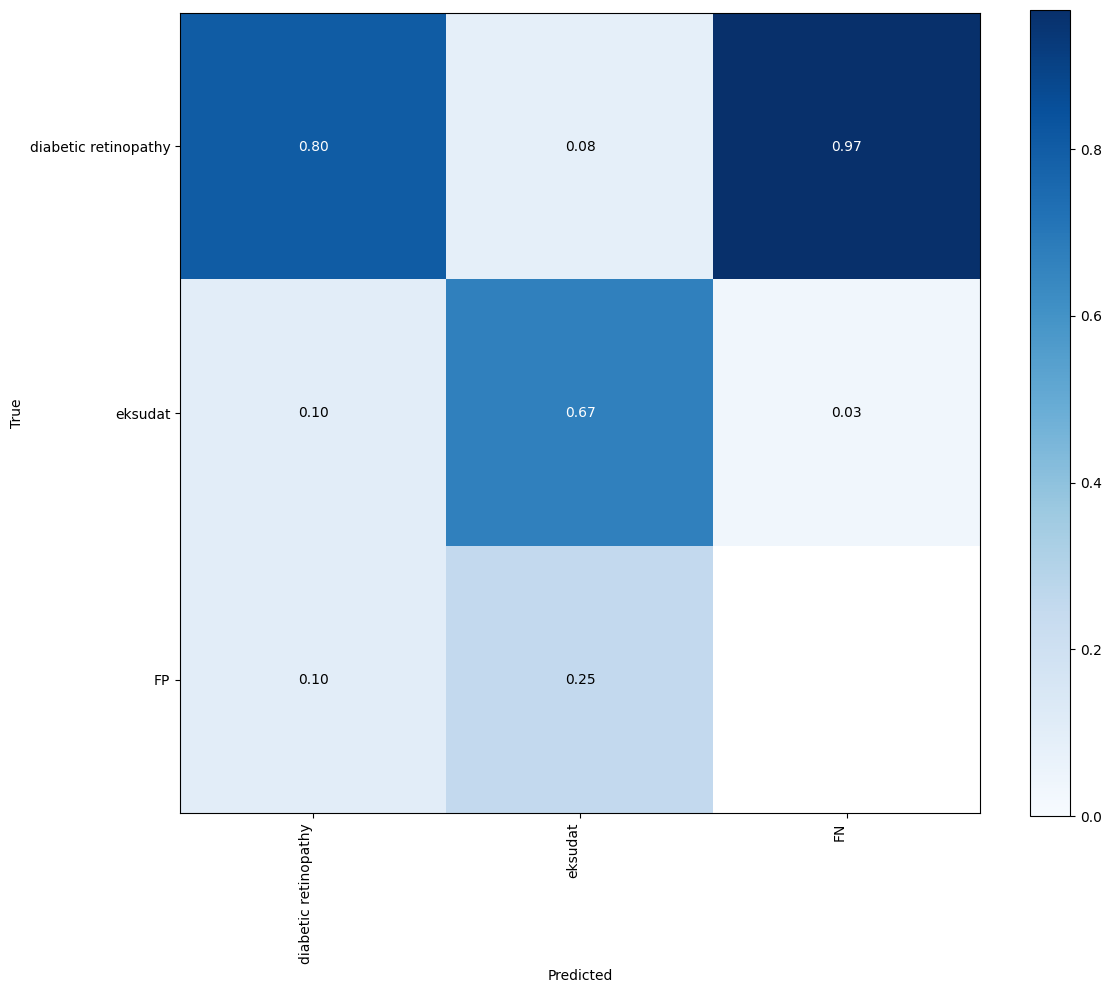

In [41]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot(normalize=True)

In [42]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open("/content/fine-tuned-paligemma-3b-pt-224.f16.npz", "wb") as f:
  np.savez(f, **{k: v for k, v in flat})